## Replicating Batchkarov et al. (2016) _A critique of word similarity as a method for evaluating distributional semantic models_

This paper argues that the intrinsic evaluation of word embeddings with existing word similarity datasets is problematic. In particular, they argue the following:

- that "word similarity" doesn't make sense outside of the context of a specific task,
- that inter-annotator agreement is low on existing datasets,
- and that the small size of existing datasets leads to too much variation in single number measures. 

I understand their conclusion to be that while word similarity can be used as a coarse evaluation, extrinsic methods should be preferred over intrinsic methods. They also have an interesting proposal for salvaging word similarity as an evaluation method, namely, use word similarity datasets that give increasingly worse evaluations to embeddings as random noise is added.

While Batchkarov et al. do make [their code](https://github.com/mbatchkarov/repeval2016) public, I'd like to do it myself as a learning experience.

They explore five word similarity datasets:

|  Name  	|              Paper             	|
|:------:	|:------------------------------	|
|   RG   	| Rubenstein & Goodenough (1965) 	|
|   MC   	|     Miller & Charles (1995)    	|
|  WS353 	|    Finkelstein et al. (2001)   	|
|   MEN  	|       Bruni et al. (2014)      	|
| SimLex 	|       Hill et al. (2015)       	|

## Definition of word similarity

Their first point is that "word similarity" could mean many different things. They note that many word similarity datasets do not distinguish/are not balanced for lexical semantic relationships (synonymy, antonymy, homonymy, etc.)

In [1]:
## Are the five datasets balanced balanced across lexical relationships?

In [2]:
## Is there a relationship between lexical relationship and empirical similarity?

In [3]:
## Do the five datasets have POS distributions similar to natural text?

In [4]:
## Larger question: Are the five datasets representative of English? Are these words typical English words?

They next note that the similarity judgements assigned to the same pair across datasets differs widely.

In [5]:
import os
import pandas as pd

In [6]:
data_dir = '../evaluate/data'

rg65_path = 'rg-65/rg-65.csv'
mc_path = 'mc/mc.csv'
ws353_path = 'ws-353/ws-353.csv'
men_path = 'men/men.csv'
simlex_path = 'simlex/simlex.csv'

rg65 = pd.read_csv(os.path.join(data_dir, rg65_path))
mc = pd.read_csv(os.path.join(data_dir, mc_path))
ws353 = pd.read_csv(os.path.join(data_dir, ws353_path))
men = pd.read_csv(os.path.join(data_dir, men_path))
simlex = pd.read_csv(os.path.join(data_dir, simlex_path))

In [7]:
ws353.head()

,word1,word2,similarity,which_set?,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,love,sex,6.77,set1,9.0,6.0,8.0,8.0,7.0,8.0,8.0,4.0,7.0,2.0,6.0,7.0,8.0,NaN,NaN,NaN
1,tiger,cat,7.35,set1,9.0,7.0,8.0,7.0,8.0,9.0,8.5,5.0,6.0,9.0,7.0,5.0,7.0,NaN,NaN,NaN
2,tiger,tiger,10.00,set1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN
3,book,paper,7.46,set1,8.0,8.0,7.0,7.0,8.0,9.0,7.0,6.0,7.0,8.0,9.0,4.0,9.0,NaN,NaN,NaN
4,computer,keyboard,7.62,set1,8.0,7.0,9.0,9.0,8.0,8.0,7.0,7.0,6.0,8.0,10.0,3.0,9.0,NaN,NaN,NaN


Concretely, they point out that the pair "chicken-rice" has a normalized score of 0.14 in SimLex but 0.68 in MEN. And that the pair "man-woman" has 0.33 in SimLex but 0.84 in MEN. 

In [8]:
simlex[(simlex['word1']=='chicken') & (simlex['word2']=='rice')]

,word1,word2,POS,similarity,word1_concreteness,word2_concreteness,concreteness_quartile,nelson_norms,top_333_in_nelson,similarity_sd
451,chicken,rice,N,1.43,4.8,4.86,4,0.27,0,1.47


In [9]:
men[(men['word1']=='chicken') & (men['word2']=='rice')]

,word1,word2,similarity_out_of_50,similarity
909,chicken,rice,34.0,6.8


OK, I have two points here:
- Is it OK to normalize similarity scores that weren't originally on a 1-10 scale? (What if the true measurement isn't linear?) I'll put this aside for now.
- What other word pairs do these datasets have in common? Let's take a look.

Merge datasets together on the two word columns.

In [10]:
datasets = ['rg65', 'mc', 'ws353', 'men']
df = simlex[['word1', 'word2', 'similarity']]
df.columns = ['word1', 'word2', 'simlex']

for name in datasets:
    other = eval(name)[['word1', 'word2', 'similarity']]
    other.columns = ['word1', 'word2', name]
    df = pd.merge(df, other, how='outer', on=['word1', 'word2'])

Word pairs present in more than one dataset will less than four NaN in a row

In [11]:
duplicates = df[['rg65', 'mc', 'ws353', 'men', 'simlex']].isnull().sum(axis=1) < 4

In [12]:
duplicates.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [13]:
tmp = df[duplicates][['simlex', 'rg65', 'mc', 'ws353', 'men']].values

In [14]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.spatial.distance import pdist

In [15]:
# this is hacky, I'd like to have a better solution than this.
values = df[duplicates][['simlex', 'rg65', 'mc', 'ws353', 'men']].values
distances = []
for row in values:
    row = row.reshape(-1,1)
    d = pdist(row)
    distances.extend([i for i in d if not np.isnan(i)])

This is the distribution of (absolute) discrepancies between the five datasets on a 10-point scale.

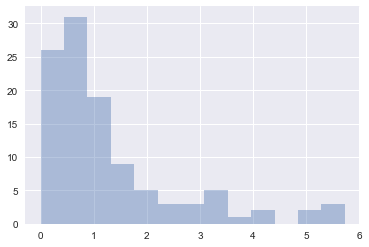

In [16]:
sns.distplot(distances, kde=False);

In [17]:
from scipy import stats

In [18]:
stats.halfnorm.fit(distances)

(-2.967480221776942e-08, 1.8331562835698065)

The distances are centered close enough to 0, with std 1.8.

To sum up, as Batchkarov-et-al point out, these datasets do give different estimates of word similarity from each other. The two examples they give are from the upper limit, as most absolute differences are less than 2. 

They go from this to the argument that a single global measure of word similarity is not appropriate, that each downstream task defines its own similarity measure. I can be sympathetic to that view, but I'm not sure of the link between inter-dataset variabaility and task-specific word similarity measures.

### Subjectivity and task difficulty

The previous section was largely about inter-dataset agreement. In this section, the authors look at inter-annotator agreement within two datasets: ws353 and MEN. These datasets come with individual level ratings, whereas MC and RG65 do not. SimLex comes with the standard deviation of the annotators' ratings. In SimLex, each pair was rated by approximately 50 humans. It seems a little odd that Batchkarov-et-al don't look at SimLex's inter-annotator agreement.

OK, now I'm a little confused by the mismatch between the text in the paper and the MEN dataset. The MEN dataset is 3,000 word pairs rated by *many* humans on MTurk. The resulting number per word pair is an aggregrate from all those judgements. Concretely, each of the 3,000 word pairs was randomly matched with another word pair 50 times. Each of those "word-pair pairs" was seen by *one* human, whose task was to say whether the first or the second word pair was more similar. Therefore, each word pair was ranked a total of 50 times against 50 different word pairs by 50 different humans. The score for a word pair is the number of times it was rated more similar than the other word pair. Then that score was normalized (by me). 

The density plot in the paper uses data from two annotators. Those two annotators are two of the authors of the paper. They rated each of the 3,000 word pairs on a 1-7 scale. Their data is not really part of the MEN dataset. I understand that data to be a simple sanity check of the methodology of the real MEN dataset. The authors calculate the correlation between the data they annotated and the data of the MTurkers. 

So in sum, I don't feel that the individual level data from the MEN dataset, collected from only two people, is a worthwhile dataset to talk about.

In [83]:
elias = pd.read_csv(os.path.join(data_dir, 'men/elias-men.csv'))
marcos = pd.read_csv(os.path.join(data_dir, 'men/marcos-men.csv'))
elias.head()

,word1,word2,similarity_out_of_7,similarity
0,hamster,party,1,0.000000
1,bed,sleep,6,8.333333
2,raspberry,strawberry,6,8.333333
3,cooking,fruit,5,6.666667
4,downtown,shopping,4,5.000000


In [93]:
elias_and_marcos = pd.merge(elias, marcos, on=['word1', 'word2'], how='inner', suffixes=['_elias', '_marcos'])
elias_and_marcos[['similarity_elias', 'similarity_marcos']].head()

,similarity_elias,similarity_marcos
0,0.000000,0.000000
1,8.333333,8.333333
2,8.333333,8.333333
3,6.666667,5.000000
4,5.000000,5.000000


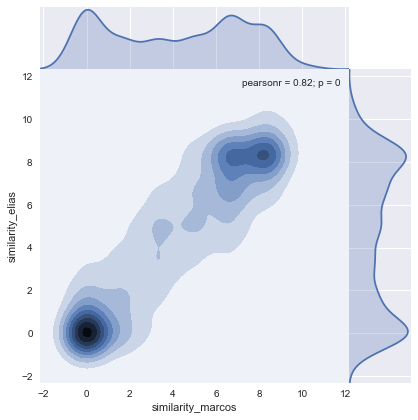

In [96]:
sns.jointplot(y='similarity_elias', x='similarity_marcos', data=elias_and_marcos, kind='kde', space=0);

This is Figure 1a in the paper. Looking at the marginal distributions, I'm confident I've got the x and y axes right. However, the density plot looks slightly different to theirs, and more worringly, I get a different (higher) pearson's r statistic. The qualitative picture is the same, but I'd like to know where the discrepancy comes from.

## To be continued

Here's what I need to do next:
- Figure out my replication of Figure 1a doesn't match up with theirs.
- Continue replicating this section then the rest of the paper.
- Look at what they did in their notebooks, potentially replicate.
- Summarise what I learnt from this replication, and list/complete any loose ends (i.e. extensions).

They also mention the variation in the ws353 dataset, saying that "tiger-cat" gets a normalized score from 0.5 to 0.9 from the 13 annotators. Let's look at how varied the ws353 is across all word pairs. And let's see where the "tiger-cat" data point is too

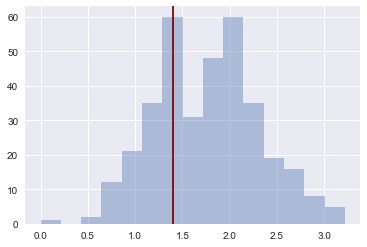

In [47]:
ratings_cols = [str(i) for i in range(1, 17)]
sns.distplot(ws353[ratings_cols].std(axis=1), kde=False);
tiger_cat = ws353[(ws353['word1']=='tiger')&(ws353['word2']=='cat')][ratings_cols].std(axis=1).values[0]
plt.axvline(tiger_cat, color='maroon');

OK, so there is a large amount of variation across annotators within the ws353 dataset. It surprises me that Batchkarov-et-al used 'tiger-cat' as their example, when clearly there are more variable words to prove that point (although this plot would have been more informative). What's the most variable word pair?

In [66]:
most_variable = ws353[ratings_cols].std(axis=1).idxmax()
ws353.loc[most_variable][['word1', 'word2']]

word1    precedent
word2      example
Name: 134, dtype: object

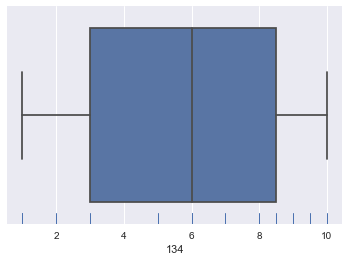

In [65]:
sns.boxplot(ws353.loc[most_variable][ratings_cols].astype(np.float64).dropna());
sns.rugplot(ws353.loc[most_variable][ratings_cols].astype(np.float64).dropna());

That's about as variable as you can get: everything from 1 to 10 for the pair "precedent-example".

What are other word pairs with high variation? Let's look at all the word pairs in the fourth quartile of std.

In [70]:
ws353[ratings_cols].std(axis=1).describe()

count    353.000000
mean       1.757647
std        0.551093
min        0.000000
25%        1.320451
50%        1.760386
75%        2.115268
max        3.217042
dtype: float64

In [72]:
fourth_quartile = ws353[ratings_cols].std(axis=1).quantile(0.75)

In [79]:
ws353[ws353[ratings_cols].std(axis=1) >= fourth_quartile]

,word1,word2,similarity,which_set?,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
18,smart,stupid,5.81,set1,3.0,7.00,9.0,9.0,5.0,8.0,6.0,0.0,6.5,3.0,5.0,7.0,7.0,NaN,NaN,NaN
26,stock,live,3.73,set1,8.0,5.50,6.0,1.0,4.0,5.0,0.0,0.0,1.0,6.0,2.0,3.0,7.0,NaN,NaN,NaN
35,king,rook,5.92,set1,7.0,7.50,7.0,6.0,7.0,8.0,8.5,0.0,8.0,0.0,6.0,5.0,7.0,NaN,NaN,NaN
39,holy,sex,1.62,set1,3.0,0.00,5.0,2.0,1.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
48,Arafat,Jackson,2.50,set1,4.0,7.50,0.0,2.0,3.0,1.0,0.0,0.0,4.0,1.0,6.0,2.0,2.0,NaN,NaN,NaN
60,drink,car,3.04,set1,7.0,0.50,0.0,2.0,2.0,7.0,5.0,5.0,4.0,0.0,2.0,0.0,5.0,NaN,NaN,NaN
63,drink,eat,6.87,set1,8.0,8.75,9.0,9.0,3.0,7.0,8.0,9.0,7.5,0.0,5.0,7.0,8.0,NaN,NaN,NaN
65,drink,mother,2.65,set1,3.0,1.00,1.0,3.0,3.0,7.0,0.0,2.0,6.5,0.0,4.0,1.0,3.0,NaN,NaN,NaN
79,brother,monk,6.27,set1,8.0,7.00,8.0,8.0,5.0,7.0,8.5,7.0,5.0,0.0,8.0,5.0,5.0,NaN,NaN,NaN
80,crane,implement,2.69,set1,3.0,6.00,1.0,1.0,4.0,1.0,0.0,6.0,1.0,0.0,9.0,3.0,0.0,NaN,NaN,NaN


Two things, both that I'll leave for another time:
- Some of these look like they're being pulled down by a single 0. I wonder if a more robust measure, like IQR, would yield different word pairs.
- Can we use this data to see how different annotators are rating word pairs? For example, can we know whether annotator 8, for example, is scoring associated, but not similar, words highly whereas another annotator might not? This idea isn't fully fleshed out yet.